### I. Import Required Dependecies

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from PIL import Image # Can be used but cv2 is primary for this version
import cv2 # OpenCV for image reading/processing

# TensorFlow & Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # Added EarlyStopping
from tensorflow.keras.optimizers import Adam # Changed from optimizers import *
# Removed Keras ImageDataGenerator - replaced by custom Sequence
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
# Import the specific preprocessing function for DenseNet
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
# Removed Activation, MaxNorm, model_from_json, l2, Conv2D, MaxPooling2D, VGG16 if not used

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # Added for label handling

# Albumentations
import albumentations as A # Added for augmentation

print("TensorFlow Version:", tf.__version__)
print("Albumentations Version:", A.__version__) # Added
print("OpenCV Version:", cv2.__version__)       # Added

2025-05-01 16:25:30.384884: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 16:25:30.431121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-01 16:25:30.431170: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow Version: 2.9.0
Albumentations Version: 1.4.18
OpenCV Version: 4.11.0


/home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### II. Read Dataset and Setup Paths

In [ ]:
# Path to the Directory Containing the Images
dataset_dir = '../Dataset_BUSI_with_GT'

# Model Saving Configuration (New)
model_save_dir = './model_minimal_augment'
weights_path = '../model/weights/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5' # Path to pre-trained weights if needed locally
best_model_path = './model_minimal_augment/best_model.keras' # Path to the best model
os.makedirs(model_save_dir, exist_ok=True)

# --- NEW: Robust Data Collection (Replaces old glob method and Section IV) ---
if not os.path.isdir(dataset_dir):
    raise ValueError(f"Dataset directory not found at: {dataset_dir}")

data_paths = []
labels = []
class_names = sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])
print(f"Found classes: {class_names}")

for folder_name in class_names:
    folder_path = os.path.join(dataset_dir, folder_name)
    files = glob.glob(os.path.join(folder_path, '*.*'))
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

    original_images = []
    skipped_masks = 0
    skipped_invalid = 0 # Added check
    for f in image_files:
        base_name = os.path.basename(f).lower()
        # Filter out masks
        if '_mask' in base_name:
            skipped_masks += 1
            continue
        # Optional: Basic check for image validity
        try:
             img_check = cv2.imread(f)
             if img_check is None or len(img_check.shape) < 2 or img_check.shape[0] < 10 or img_check.shape[1] < 10:
                 print(f"Warning: Image seems invalid or unreadable, skipping: {f}")
                 skipped_invalid +=1
                 continue
        except Exception as e:
             print(f"Warning: Error reading image {f}, skipping. Error: {e}")
             skipped_invalid += 1
             continue
        original_images.append(f)

    print(f"Class '{folder_name}': Found {len(original_images)} original images (skipped {skipped_masks} masks, {skipped_invalid} invalid).")

    for file_path in original_images:
        data_paths.append(file_path)
        labels.append(folder_name)

# Create DataFrame from collected paths and labels
all_data_df = pd.DataFrame({'Path': data_paths, 'Label': labels})

print(f"\nTotal original images loaded: {len(all_data_df)}")
if len(all_data_df) == 0:
    raise ValueError("No valid images found after filtering. Check dataset path and mask naming.")

# Display Sample Data
print("Sample data:")
print(all_data_df.head())

NameError: name 'model_save_dir' is not defined

### III. Data Visualization

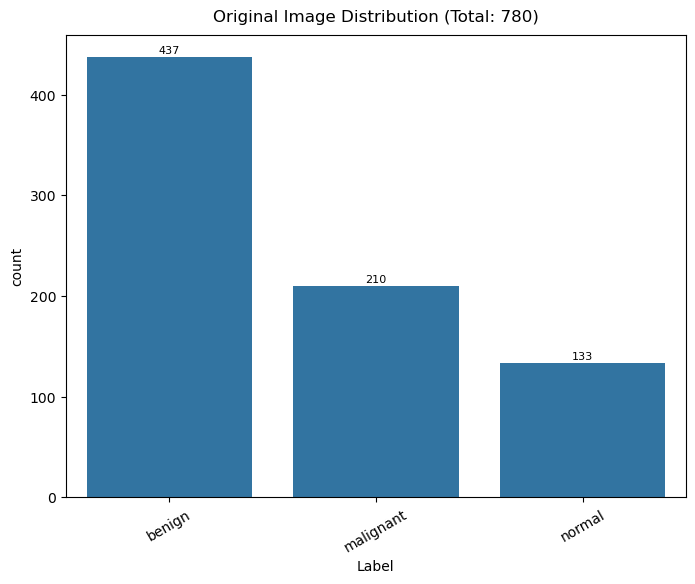

In [4]:
# Display Overall Class Distribution (Using the filtered DataFrame)
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Label', data=all_data_df, order=class_names) # Use filtered df
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)
plt.xticks(rotation=30)
plt.title(f'Original Image Distribution (Total: {len(all_data_df)})', pad=10) # Updated title
plt.show()

### IV. Data Preprocessing & Data Generation Pipeline

In [5]:
# --- Configuration ---
batch_size = 16
image_height = 256
image_width = 256
num_channels = 3 # DenseNet expects 3 channels
image_size = (image_height, image_width)
image_shape = (image_height, image_width, num_channels)
num_classes = len(class_names) # Get num_classes dynamically

# --- Label Encoding ---
label_encoder = LabelEncoder()
all_data_df['Label_Encoded'] = label_encoder.fit_transform(all_data_df['Label'])
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(f"\nClass mapping: {class_mapping}")

# --- Data Splitting (with Stratification) ---
# Using random_state=123 for consistency if needed, added stratification
train_df, val_test_df = train_test_split(
    all_data_df,
    train_size=0.8,
    shuffle=True,
    random_state=123,
    stratify=all_data_df['Label_Encoded'] # Added stratification
)
val_df, test_df = train_test_split(
    val_test_df,
    train_size=0.5,
    shuffle=True,
    random_state=123,
    stratify=val_test_df['Label_Encoded'] # Added stratification
)

print(f"\nDataset Split:")
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
# Optional: print class distribution per set
# print("\nTrain Data Distribution:"); print(train_df['Label'].value_counts())
# print("\nValidation Data Distribution:"); print(val_df['Label'].value_counts())
# print("\nTest Data Distribution:"); print(test_df['Label'].value_counts())

# --- Albumentations Augmentation Definitions ---
print("\nDefining Albumentations transforms...")
# Using MINIMAL augmentations based on previous results
train_transform = A.Compose([
    A.Resize(height=image_height, width=image_width, interpolation=cv2.INTER_LINEAR),
    A.HorizontalFlip(p=0.5), # Only random augmentation
])
val_test_transform = A.Compose([
    A.Resize(height=image_height, width=image_width, interpolation=cv2.INTER_LINEAR) # Resize only for val/test
])
print("Using MINIMAL augmentations: Resize + HorizontalFlip only for training.")

# --- Custom Keras Data Generator (Replaces ImageDataGenerator) ---
print("Defining custom DataGenerator Sequence...")
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size, image_size, num_classes, augmentations=None, shuffle=True, preprocess_fn=None):
        self.df = df.copy()
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.augmentations = augmentations
        self.shuffle = shuffle
        self.preprocess_fn = preprocess_fn # Added for DenseNet preprocessing
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indices]
        X = np.zeros((len(batch_df), *self.image_size, num_channels), dtype=np.float32)
        y = np.zeros((len(batch_df), self.num_classes), dtype=np.float32)

        for i, (idx, row) in enumerate(batch_df.iterrows()):
            img_path = row['Path']
            label_encoded = row['Label_Encoded']
            img = cv2.imread(img_path)
            if img is None:
                # Handle error: print warning and use zeros
                print(f"Warning: Could not read image {img_path} in generator. Filling with zeros.")
                img = np.zeros((*self.image_size, num_channels), dtype=np.uint8)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            if self.augmentations: # Apply Albumentations
                augmented = self.augmentations(image=img)
                img = augmented['image']

            # Ensure correct size after augmentation (fallback)
            if img.shape[0] != self.image_size[0] or img.shape[1] != self.image_size[1]:
                 img = cv2.resize(img, (self.image_size[1], self.image_size[0]), interpolation=cv2.INTER_LINEAR)

            img = img.astype(np.float32)
            # Apply specific DenseNet preprocessing function
            if self.preprocess_fn:
                img = self.preprocess_fn(img)
            else: # Fallback (should not be used with DenseNet)
                 img = img / 255.0

            X[i,] = img
            y[i,] = to_categorical(label_encoded, num_classes=self.num_classes) # One-hot encode

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# --- Instantiate Data Generators ---
print("\nCreating Data Generators...")
train_generator = DataGenerator(
    train_df, batch_size, image_size, num_classes,
    augmentations=train_transform, shuffle=True,
    preprocess_fn=densenet_preprocess_input # Use DenseNet preprocessing
)
valid_generator = DataGenerator(
    val_df, batch_size, image_size, num_classes,
    augmentations=val_test_transform, shuffle=False, # No shuffle/augmentation for validation
    preprocess_fn=densenet_preprocess_input
)
test_generator = DataGenerator( # Added test generator definition here
    test_df, batch_size, image_size, num_classes,
    augmentations=val_test_transform, shuffle=False, # No shuffle/augmentation for test
    preprocess_fn=densenet_preprocess_input
)

print(f"Train generator: {len(train_generator)} batches")
print(f"Validation generator: {len(valid_generator)} batches")
print(f"Test generator: {len(test_generator)} batches")

# --- Visualize Augmented Images (Corrected Method) ---
print("\nVisualizing sample augmented training images (BEFORE DenseNet preprocessing)...")

# Get the first batch's indices from the generator to find corresponding df rows
batch_indices = train_generator.indices[0 * train_generator.batch_size:(0 + 1) * train_generator.batch_size]
batch_df_sample = train_generator.df.iloc[batch_indices]

plt.figure(figsize=(12, 8))
num_images_to_show = min(len(batch_df_sample), 8) # Show up to 8 images or batch size

for i in range(num_images_to_show):
    try:
        # Get the image path and label from the dataframe for this index
        img_path = batch_df_sample.iloc[i]['Path']
        label_encoded = batch_df_sample.iloc[i]['Label_Encoded']
        label_name = label_encoder.inverse_transform([label_encoded])[0]

        # --- Re-load the original image ---
        img_original = cv2.imread(img_path)
        if img_original is None:
            print(f"Warning: Could not reload image {img_path} for visualization.")
            continue
        img_rgb = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB) # Convert to RGB

        # --- Apply ONLY the Albumentations transform ---
        # This shows the output of train_transform before DenseNet preprocessing
        augmented_data = train_transform(image=img_rgb)
        img_augmented_display = augmented_data['image'] # This is uint8 [0, 255]

        # --- Display the result of Albumentations ---
        plt.subplot(2, 4, i + 1)
        plt.imshow(img_augmented_display) # Display the correctly augmented image
        plt.title(f"Label: {label_name}\n(Augmented)")
        plt.axis('off')

    except Exception as e:
        print(f"Error visualizing image index {i}: {e}")
        # Optionally display a blank subplot or skip
        plt.subplot(2, 4, i + 1)
        plt.title("Error Loading")
        plt.axis('off')


plt.suptitle("Sample Augmented Training Images (Result of Albumentations)")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()


# --- Display Class Indices (as in old notebook) ---
# Get class indices from the generator (useful for mapping predictions)
# class_indices = train_generator.class_indices # Custom generator doesn't have this attribute directly
# Use the mapping created earlier
print("\nClass Indices Mapping Used:")
print(class_mapping)

NameError: name 'class_names' is not defined

### V. BUILD MODEL

In [7]:
# VI. Build Model
print("\nBuilding Model...")

# Check if weights file exists if loading locally
# if not os.path.isfile(weights_path):
#      raise ValueError(f"DenseNet weights file not found at: {weights_path}")

# Load the DenseNet-121 base model
base_model = DenseNet121(
    # weights=weights_path, # Use local weights if needed
    weights='imagenet',    # Or load directly from Keras repository
    include_top=False,     # Exclude the final Dense layers
    input_shape=image_shape # Use defined image shape
)

# Freeze base model layers
base_model.trainable = False
print("DenseNet121 base model loaded and frozen.")

# Create the Sequential model with custom head
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu', name='dense_1024_1'),
    Dropout(0.4, name='dropout_1'), # Added dropout
    Dense(512, activation='relu', name='dense_512'),
    Dropout(0.2, name='dropout_2'), # Added dropout
    Dense(128, activation='relu', name='dense_128'),
    Dense(num_classes, activation='softmax', name='output') # Output layer size matches num_classes
], name='Breast_Tumor_Classifier_Minimal_Augment') # Model name updated

# Display model summary
model.summary()

# --- Define Callbacks ---
print("\nDefining Callbacks...")
# Model Checkpoint Callback
checkpoint = ModelCheckpoint(
    best_model_path,            # Path to save the best model
    monitor='val_accuracy',     # Monitor validation accuracy
    save_best_only=True,        # Save only the best
    mode='max',                 # Maximize monitored metric
    verbose=1                   # Print messages
)
print(f"Model checkpoints will be saved to {best_model_path}")

# Early Stopping Callback (New)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,            # Stop after 10 epochs of no improvement
    verbose=1,
    mode='max',
    restore_best_weights=True # Restore weights from the best epoch
)
print("Early stopping configured (patience=10 on val_accuracy).")


Building Model...


2025-05-01 16:17:52.428376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 16:17:52.428732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-01 16:17:52.428832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-01 16:17:52.428872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64]

DenseNet121 base model loaded and frozen.
Model: "Breast_Tumor_Classifier_Minimal_Augment"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense_1024_1 (Dense)        (None, 1024)              67109888  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_512 (Dense)           (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                   

### VI. Compile Model


In [ ]:
print("\nCompiling Model...")
# Using Adam optimizer with a potentially lower learning rate
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
print("Model Compiled Successfully.")

### VII. Train Model

In [3]:
# --- THIS SECTION IS COMMENTED OUT AS THE PROVIDED CODE LOADS A PRE-TRAINED MODEL ---
# print("\nStarting Training...")
# epochs = 50 # Define number of epochs

# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=valid_generator,
#     callbacks=[checkpoint, early_stopping], # Use both callbacks
#     # steps_per_epoch and validation_steps inferred from generator length
#     verbose=1
# )
# print("Training Finished.")
# --- END OF COMMENTED OUT TRAINING SECTION ---
best_model_path = '../model_minimal_augment/best_model.keras' # Path to the best model
# --- Load Best Model (as per provided new code) ---
print(f"\n--- Loading Pre-Trained Best Model ---")
print(f"Attempting to load model from: {best_model_path}")
try:
    # Load the best model explicitly saved by the checkpoint callback during a previous run
    model = load_model(best_model_path)
    print("Best model loaded successfully for evaluation.")
    # Verify the model architecture after loading (optional)
    # model.summary()
except Exception as e:
    print(f"ERROR: Could not load the model from {best_model_path}.")
    print(f"Ensure the model was trained and saved correctly in a previous run.")
    print(f"Error details: {e}")
    # Depending on workflow, you might want to raise an error or exit here
    # raise RuntimeError("Failed to load the required model for evaluation.") from e
    model = None # Set model to None if loading failed


--- Loading Pre-Trained Best Model ---
Attempting to load model from: ../model_minimal_augment/best_model.keras


2025-05-01 16:28:53.225567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-01 16:28:53.225999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-01 16:28:53.226415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/chaoder/miniconda3/envs/tumor_classification/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-01 16:28:53.226654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64]

Best model loaded successfully for evaluation.


### VIII. Evaluate Model (Train & Validation Set)


In [4]:
if model is not None: # Only proceed if model loaded successfully
    print("\nEvaluating best model on Training and Validation Sets...")
    # Note: Evaluating on train_generator after loading might reflect last state,
    # but standard practice evaluates the *best* checkpoint.
    train_loss, train_accuracy = model.evaluate(train_generator, verbose=0)
    val_loss, val_accuracy = model.evaluate(valid_generator, verbose=0)

    train_accuracy_percentage = train_accuracy * 100
    val_accuracy_percentage = val_accuracy * 100
    evaluation_results = pd.DataFrame({
        'Set': ['Train', 'Validation'],
        'Loss': [train_loss, val_loss],
        'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
    })
    print("\nLoaded Model Evaluation (Train/Validation):")
    print(evaluation_results)

    # Plot Loss & Accuracy Curves
    # --- THIS SECTION WILL CAUSE AN ERROR IF TRAINING WASN'T RUN IN THIS SESSION ---
    # Because the 'history' object is not available when loading a saved model directly.
    print("\nPlotting Training History... (Requires 'history' object from training)")
    # Wrap in try-except or only run if model.fit was executed in the same session
    try:
        # This part assumes 'history' variable exists from model.fit()
        train_history_df = pd.DataFrame(history.history)
        final_epoch = len(train_history_df)
        train_history_df['Epoch'] = range(1, final_epoch + 1)

        plt.figure(figsize=(14, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_history_df['Epoch'], train_history_df['loss'], label='Training Loss')
        plt.plot(train_history_df['Epoch'], train_history_df['val_loss'], label='Validation Loss')
        plt.title('Training & Validation Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(train_history_df['Epoch'], train_history_df['accuracy'], label='Training Accuracy')
        plt.plot(train_history_df['Epoch'], train_history_df['val_accuracy'], label='Validation Accuracy')
        plt.title('Training & Validation Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
        plt.tight_layout()
        plot_save_path = os.path.join(model_save_dir, 'training_history_plot.png')
        plt.savefig(plot_save_path)
        print(f"Training history plot saved to {plot_save_path}")
        plt.show()
    except NameError:
        print("Variable 'history' not defined. Cannot plot training history.")
        print("Run model.fit() in the current session to generate history.")
    except Exception as e:
        print(f"An error occurred while plotting history: {e}")
    # --- END OF PLOTTING SECTION ---

else:
    print("\nSkipping Evaluation and Plotting as model loading failed.")


Evaluating best model on Training and Validation Sets...


NameError: name 'train_generator' is not defined